# 23/01/2024 - Hand Gesture Recognition

---


# Setup


## Install Dependencies


In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Import libraries


In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import time
import os

In [3]:
tf.get_logger().setLevel("ERROR")

In [4]:
%load_ext tensorboard

In [5]:
%tensorboard --logdir logs/fit

# Data Preprocessing


In [6]:
DATASET_PATH = "./datasets/distance_and_angles_gestures_dataset.csv"

ADDITIONAL_DATASETS = [
    "./datasets/more_closed_hands_dataset.csv",
    "./datasets/additional_dataset.csv",
]

### Read CSV and split inputs from labels


In [7]:
from helpers.data import write_labels

dataset = pd.read_csv(DATASET_PATH)

for dataset_path in ADDITIONAL_DATASETS:
    additional_dataset = pd.read_csv(dataset_path)
    dataset = pd.concat([dataset, additional_dataset])

print("is any NA in dataset ?", dataset.isna().any().any())
print("is any null in dataset ?", dataset.isnull().any().any())

# print na values
print(dataset.isna().sum())


labels = dataset["label"]
inputs = dataset.drop("label", axis=1)


inputs = inputs.to_numpy()
inputs = inputs.astype("float32")

X = inputs

dummies = pd.get_dummies(
    labels
)  # Creates a df of labels as categorical (ex : "closed" = [1, 0, 0, ..., 0])

classes = dummies.columns.to_list()
write_labels("./", classes)

labels = dummies.to_numpy()
labels = labels.astype("int64")


print(f"Input shape : {X[0].shape}")
print(f"Output shape : {labels[0].shape}")

is any NA in dataset ? False
is any null in dataset ? False
LEFT_HAND                                0
RIGHT_HAND                               0
THUMB_CMC_DISTANCE_FROM_WRIST            0
THUMB_MCP_DISTANCE_FROM_WRIST            0
THUMB_IP_DISTANCE_FROM_WRIST             0
THUMB_TIP_DISTANCE_FROM_WRIST            0
INDEX_FINGER_MCP_DISTANCE_FROM_WRIST     0
INDEX_FINGER_PIP_DISTANCE_FROM_WRIST     0
INDEX_FINGER_DIP_DISTANCE_FROM_WRIST     0
INDEX_FINGER_TIP_DISTANCE_FROM_WRIST     0
MIDDLE_FINGER_MCP_DISTANCE_FROM_WRIST    0
MIDDLE_FINGER_PIP_DISTANCE_FROM_WRIST    0
MIDDLE_FINGER_DIP_DISTANCE_FROM_WRIST    0
MIDDLE_FINGER_TIP_DISTANCE_FROM_WRIST    0
RING_FINGER_MCP_DISTANCE_FROM_WRIST      0
RING_FINGER_PIP_DISTANCE_FROM_WRIST      0
RING_FINGER_DIP_DISTANCE_FROM_WRIST      0
RING_FINGER_TIP_DISTANCE_FROM_WRIST      0
PINKY_MCP_DISTANCE_FROM_WRIST            0
PINKY_PIP_DISTANCE_FROM_WRIST            0
PINKY_DIP_DISTANCE_FROM_WRIST            0
PINKY_TIP_DISTANCE_FROM_WRIST        

### Split data into training and testing sets


In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42
)
print(f"Total dataset size : {len(X)}")
print("====================================")

print(f"Train dataset size : {len(x_train)}")
print(f"Test dataset size : {len(x_test)}")

Total dataset size : 93826
Train dataset size : 75060
Test dataset size : 18766


In [9]:
input_shape = X.shape[1]
output_shape = len(classes)
print(f"Input is of shape : {input_shape}")
print(f"Output is of shape : {output_shape}")

Input is of shape : 42
Output is of shape : 8


# Create the model


In [10]:
LOAD_MODEL = False
MODEL_LOAD_PATH = "./models/4february/4february.hdf5"

LEARNING_RATE = 0.0001
REGULARIZATION_RATE = 0.001
DROPOUT = 0.2

In [11]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

from helpers.misc import get_model_name

model_name = ""


if LOAD_MODEL:
    model_name = MODEL_LOAD_PATH.split("/")[-1].split(".")[0]
    model = load_model(MODEL_LOAD_PATH)

else:
    model_name = get_model_name()

    regularizer = regularizers.l2(REGULARIZATION_RATE)

    model = Sequential(
        [
            Input(shape=[input_shape]),
            #
            Dense(32, activation="relu", kernel_regularizer=regularizer),
            BatchNormalization(),
            Dropout(rate=DROPOUT),
            #
            Dense(16, activation="relu", kernel_regularizer=regularizer),
            BatchNormalization(),
            Dropout(rate=DROPOUT),
            #
            Dense(units=output_shape, activation="softmax"),
        ]
    )

    optimizer = Adam(learning_rate=LEARNING_RATE)

    checkpointer_callback = ModelCheckpoint(
        filepath=f"models/{model_name}/{model_name}.hdf5",
        monitor="val_loss",
        verbose=False,
        save_best_only=True,
    )

    model.summary()

    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1376      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=20
)

In [13]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = (
    "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + " - " + model_name
)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
MODEL_METRICS_PATH = f"./models/{model_name}/training.log"

In [15]:
from tensorflow.keras.callbacks import CSVLogger

csv_logger_callback = CSVLogger(MODEL_METRICS_PATH, separator=",", append=True)

In [16]:
os.makedirs(f"./models/{model_name}", exist_ok=True)

# Model Training


### Hyperparameters


In [17]:
SAVE_MODEL_PATH = f"./models/{model_name}"
LOAD_MODEL = False

NUM_EPOCHS = 1000

VALIDATION_SPLIT = 0.2

BATCH_SIZE = 128
VERBOSE = 2

In [18]:
print(X.shape)
print(labels.shape)

(93826, 42)
(93826, 8)


In [19]:
from helpers.misc import get_timestamp

print(f"Training model {model_name}...\n")
start_time = time.time()


history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
    callbacks=[
        checkpointer_callback,
        csv_logger_callback,
        # early_stopping_callback,
        tensorboard_callback,
    ],
)


training_duration = get_timestamp(time.time() - start_time)

print("\n-------------\n")
print("Training complete!")
print(f"Completed training in {training_duration}")

Training model 4_feb_w_additional_datasets...

Epoch 1/1000
470/470 - 2s - loss: 2.1455 - accuracy: 0.2317 - val_loss: 1.7540 - val_accuracy: 0.4297 - 2s/epoch - 3ms/step
Epoch 2/1000


/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


470/470 - 0s - loss: 1.6883 - accuracy: 0.4126 - val_loss: 1.3627 - val_accuracy: 0.6033 - 461ms/epoch - 981us/step
Epoch 3/1000
470/470 - 0s - loss: 1.4129 - accuracy: 0.5265 - val_loss: 1.1464 - val_accuracy: 0.6676 - 467ms/epoch - 995us/step
Epoch 4/1000
470/470 - 0s - loss: 1.1928 - accuracy: 0.6202 - val_loss: 0.9109 - val_accuracy: 0.8211 - 478ms/epoch - 1ms/step
Epoch 5/1000
470/470 - 1s - loss: 1.0199 - accuracy: 0.6996 - val_loss: 0.7402 - val_accuracy: 0.8660 - 512ms/epoch - 1ms/step
Epoch 6/1000
470/470 - 1s - loss: 0.9014 - accuracy: 0.7472 - val_loss: 0.6498 - val_accuracy: 0.8668 - 513ms/epoch - 1ms/step
Epoch 7/1000
470/470 - 1s - loss: 0.8215 - accuracy: 0.7737 - val_loss: 0.5807 - val_accuracy: 0.8748 - 531ms/epoch - 1ms/step
Epoch 8/1000
470/470 - 1s - loss: 0.7600 - accuracy: 0.7964 - val_loss: 0.5409 - val_accuracy: 0.8748 - 535ms/epoch - 1ms/step
Epoch 9/1000
470/470 - 1s - loss: 0.7206 - accuracy: 0.8089 - val_loss: 0.5105 - val_accuracy: 0.8800 - 557ms/epoch - 1m

## Display model training metrics


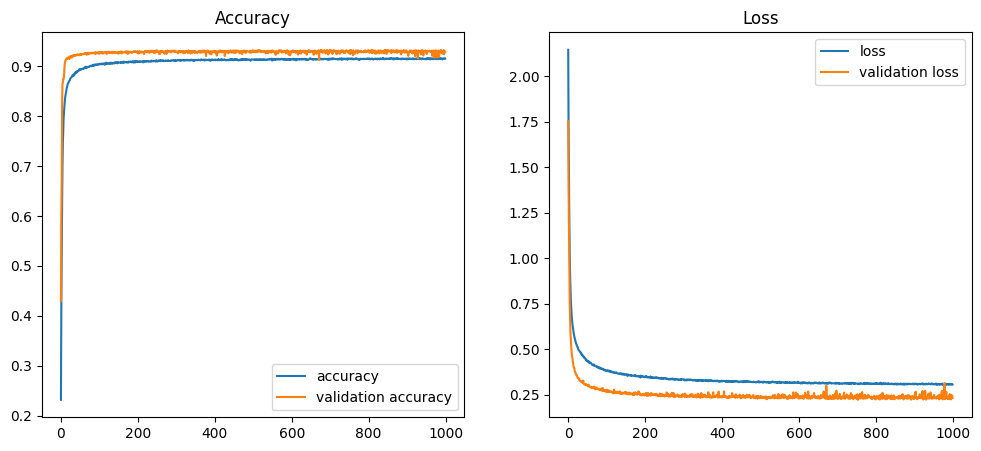

In [20]:
metrics = pd.read_csv(MODEL_METRICS_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(metrics["accuracy"], label="accuracy")
ax1.plot(metrics["val_accuracy"], label="validation accuracy")
ax1.set_title("Accuracy")

ax2.plot(metrics["loss"], label="loss")
ax2.plot(metrics["val_loss"], label="validation loss")
ax2.set_title("Loss")

ax1.legend()
ax2.legend()
plt.show()

## Evaluate the model


In [21]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=VERBOSE)


print("\n")
print(f"Perte (Loss) sur l'ensemble de test : {loss}")
print(f"Précision (Accuracy) sur l'ensemble de test : {accuracy}")

587/587 - 0s - loss: 0.2567 - accuracy: 0.9225 - 275ms/epoch - 468us/step


Perte (Loss) sur l'ensemble de test : 0.2566770017147064
Précision (Accuracy) sur l'ensemble de test : 0.9225194454193115
